In [391]:
#!/usr/bin/env python3

import io
import os
import random

import torch
import torchvision
import pandas as pd
import PIL
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from operator import itemgetter
import pickle


class CelebAImageFolderWithPaths(torchvision.datasets.ImageFolder):

    def __getitem__(self, index):
        original_tuple = super(CelebAImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]

        tuple_with_path = {
            'image': original_tuple[0],
            'target': original_tuple[1],
            'path': (path.rsplit('/', 1)[-1],)
        }
        list_img = [original_tuple[0], original_tuple[1], path.rsplit('/', 1)[-1]]
        tuple_with_path = original_tuple + (path.rsplit('/', 1)[-1],)
        return list_img


class CelebADataLoader(Dataset):

    def __init__(self, dataset_type='gt15',
                 root_dir='../one_shot_learning/data/img_alig_split/',
                 gt15_dir=os.path.join(os.getcwd(),'../one_shot_learning/data/img_alig_split_gt_15/'), split_size=0.8):
        if dataset_type == 'gt15':
            self.root_dir = gt15_dir
        else:
            self.root_dir = root_dir

        self.dataset, self.train_loader = self.load_data(self.root_dir)
        self.load_attributes_files()
        self.load_labels_names_and_files()
        self.merge_data()
        self.data_paths = self.data_labels['path']
        self.identity_classes = list(pd.Series(self.dataset.targets).unique())
        self.transform = None
        self.split_train_test(split_size)
        return

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.data_paths[idx]
        image = io.imread(img_name)

        sample = {'image': image, 'label': self.data_labels['label'][idx]}

        return sample

    def get_images_with_features(self, features):
        condition = None
        for feature in features:
            if condition is None:
                condition = (self.img_attr[feature] == 1)
            else:
                condition = (self.img_attr[feature] == 1) & condition
        list_img_conditions = list(
            self.img_attr[condition]['img_name']
        )
        images_features_filters = [img for i, img in enumerate(self.dataset)
                                   if img[2] in list_img_conditions]
        return images_features_filters

    def load_data(self, dir_imgs):
        data_path = dir_imgs
        transform = transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        train_dataset = CelebAImageFolderWithPaths(
            root=data_path,
            transform=transform
        )
        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=64,
            num_workers=0,
            shuffle=True
        )

        return train_dataset, train_loader

    def load_data_class(self, target, dataset='train'):
        ds_targets = []
        ds = None
        if dataset == 'train':
            ds = self.train_dataset
            ds_targets = self.train_targets
        elif dataset == 'test':
            ds = self.test_dataset
            ds_targets = self.test_targets
        targets = torch.tensor(ds_targets)
        target_idx = (targets == target).nonzero()
        sampler = torch.utils.data.sampler.SubsetRandomSampler(target_idx)
        loader = torch.utils.data.DataLoader(ds, sampler=sampler)
        return loader

    def get_data_subset(self, idx, dataset='train'):
        if dataset == 'train':
            ds = self.train_dataset
        elif dataset == 'test':
            ds = self.test_dataset
        targets = torch.tensor(idx)
        sampler = torch.utils.data.sampler.SubsetRandomSampler(targets)
        loader = torch.utils.data.DataLoader(ds, sampler=sampler)
        return loader

    def load_attributes_files(self, file_name='data/list_attr_celeba_processed.csv'):
        self.img_attr = pd.read_csv(os.path.join(os.getcwd(),'../one_shot_learning/data/list_attr_celeba_processed.csv'))
        return self.img_attr

    def load_labels_names_and_files(self, name=os.path.join(os.getcwd(),'../one_shot_learning/data/data_labels_names.csv')):
        self.data_labels = pd.read_csv(name)
        return self.data_labels

    def merge_data(self):
        df1 = self.img_attr
        df2 = self.data_labels
        self.merged = df1.merge(df2, left_on='img_name', right_on='img_name')
        return

    def split_train_test(self,
                         split_size=0.8,
                         shuffle_dataset=True,
                         random_seed=42):
        #dataloader_shuffle = torch.utils.data.DataLoader(self.dataset, shuffle=shuffle_dataset)
        dataset_size = len(self.dataset)
        train_size = int(split_size * dataset_size)
        test_size = dataset_size - train_size
        train_dataset, test_dataset = torch.utils.data.random_split(
            self.dataset, [train_size, test_size]
        )
        all_targets = self.dataset.targets
        train_indices = train_dataset.indices
        self.train_dataset = train_dataset
        if test_size != 0:
            self.test_dataset = test_dataset
            test_indices = test_dataset.indices
            self.test_targets = list(itemgetter(*test_indices)(all_targets))
        else:
            test_dataset = None
        self.train_targets = list(itemgetter(*train_indices)(all_targets))

        return train_dataset, test_dataset


class SiameseDatasetCreator:

    def __init__(self, split_size=0.8):
        self.celeb_loader = CelebADataLoader(split_size=split_size)

    def filter_targets(self, type_ds):
        sample_classes = None
        if type_ds == 'train':
            sample_classes = pd.Series(self.celeb_loader.train_targets)
        elif type_ds == 'test':
            sample_classes = pd.Series(self.celeb_loader.test_targets)
        return sample_classes

    def get_image_by_class(self, class_val, type_ds='train'):
        sample_classes = self.filter_targets(type_ds)
        filtered = sample_classes[sample_classes == class_val]
        idx_filtered = filtered.index
        data_filtered = self.celeb_loader.get_data_subset(idx_filtered, type_ds)
        return data_filtered, len(filtered), idx_filtered
    
    def one_example_image_by_class(self,class_val, type_ds='train'):
        sample_classes = self.filter_targets(type_ds)
        filtered = sample_classes[sample_classes == class_val]
        idx_filtered = filtered.index[0]
        data_filtered = self.celeb_loader.get_data_subset(idx_filtered, type_ds)
        return data_filtered, len(filtered), idx_filtered
        

    def get_images_excluding_class(self, class_true, type_ds='train'):
        sample_classes = self.filter_targets(type_ds)
        filtered = sample_classes[sample_classes != class_true]
        idx_filtered = filtered.index
        data_filtered = self.celeb_loader.get_data_subset(idx_filtered, type_ds)
        return data_filtered, len(filtered), idx_filtered

    def create_pair_siamese(self, class_true, type_ds='train'):
        class_1_data, nr_samples_class, filtered_idx = self.get_image_by_class(
            class_true, type_ds
        )
        targets = np.zeros((nr_samples_class,))
        targets[(nr_samples_class // 2):] = 1
        class_not_1_data, nr_samples_class_not_1, filtered_idx_not_1 = self.get_images_excluding_class(
            class_true, type_ds
        )
        nr_channels, img_height, img_width = tuple(self.celeb_loader.dataset[0][0].shape)
        pairs = [np.zeros((nr_samples_class, img_height, img_width, nr_channels)) for i in range(2)]

        for i in range(nr_samples_class):
            id_net_1 = np.random.choice(filtered_idx)
            img_class_1 = list(self.celeb_loader.get_data_subset([[id_net_1]], type_ds))[0][0].reshape(
                img_height, img_width, nr_channels
            )
            pairs[0][i, :, :, :] = img_class_1

            id_net_2_same = np.random.choice(filtered_idx)
            img_class_1_2 = list(self.celeb_loader.get_data_subset([[id_net_2_same]], type_ds))[0][0].reshape(
                img_height, img_width, nr_channels
            )

            id_net_2_diff = np.random.choice(filtered_idx_not_1)
            img_class_2 = list(self.celeb_loader.get_data_subset([[id_net_2_diff]], type_ds))[0][0].reshape(
                img_height, img_width, nr_channels
            )

            if i >= nr_samples_class // 2:
                pairs[1][i, :, :, :] = img_class_2
            else:
                pairs[1][i, :, :, :] = img_class_1_2
        return pairs, targets
    
    def get_images_for_each_class(self,type_ds='train'):
        if type_ds == 'train':
            sample_classes = pd.Series(self.celeb_loader.train_targets).unique()
        else:
            sample_classes = pd.Series(self.celeb_loader.test_targets).unique()
        all_images = []
        all_ids = []
        for class_person in sample_classes:
            class_1_data, nr_samples_class, filtered_idx = self.one_example_image_by_class(
                class_person, type_ds
            )
            
            img_class = list(self.celeb_loader.get_data_subset([[filtered_idx]], type_ds))[0][0]
            all_ids.append(class_person)
           
            all_images.append(img_class)
        return all_images, all_ids

    # batch-size defines the number of pairs we need
    def generate_verification_input(self, nr_ex_class=10, batch_size=10, type_ds='train'):
        while True:
            if type_ds == 'train':
                sample_classes = pd.Series(self.celeb_loader.train_targets).unique()
                ds = self.celeb_loader.train_dataset
            elif type_ds == 'test':
                sample_classes = pd.Series(self.celeb_loader.test_targets).unique()
                ds = self.celeb_loader.test_dataset

            for class_identity in sample_classes:
                pairs_class, target_class = self.create_pair_siamese(class_identity, type_ds)
                yield pairs_class, target_class


class PlasticDataCreator(SiameseDatasetCreator):

    def __init__(self):
        super(PlasticDataCreator, self).__init__()

    def get_nr_classes(self, type_ds='train'):
        if type_ds == 'train':
            sample_classes = pd.Series(self.celeb_loader.train_targets).unique()
            ds = self.celeb_loader.train_dataset
        elif type_ds == 'test':
            sample_classes = pd.Series(self.celeb_loader.test_targets).unique()
            ds = self.celeb_loader.test_dataset
        return sample_classes

    def get_random_class_images(self, type_ds='train', k=5):
        sample_classes = self.filter_targets(type_ds)
        idx_filtered = sample_classes.index
        random_classes_idx = random.sample(list(idx_filtered), k)
        random_class_to_pass_without_label = random.sample(random_classes_idx, 1)

        class_1_data, nr_samples_class, filtered_idx = self.get_image_by_class(
            class_val=list(sample_classes[random_class_to_pass_without_label])[0],
            type_ds=type_ds
        )
        random_pick = random.sample(list(filtered_idx), 1)
        random_classes_idx = random_classes_idx + random_pick
        data_filtered = self.celeb_loader.get_data_subset(random_classes_idx, type_ds)
        return data_filtered, random_classes_idx, \
               sample_classes[random_classes_idx], \
               sample_classes[random_pick]

    def init_steps_array_and_target(self, nr_steps=6, type_ds='train'):
        nr_classes = len(self.get_nr_classes(type_ds))
        nr_channels, img_height, img_width = tuple(self.celeb_loader.dataset[0][0].shape)

        input_step = np.zeros((nr_steps, 1,  nr_channels, img_height, img_width))
        labels = np.zeros((nr_steps, 1,  nr_classes))
        return input_step, labels

    def create_input_plastic_network(self,  k_instances=5, nr_steps=6, type_ds='train'):
        input_step, labels_step = self.init_steps_array_and_target(nr_steps, type_ds)
        random_k_images, random_idx, rand_classes, class_without_label = self.get_random_class_images(type_ds, k_instances)

        for step in range(nr_steps-1):
            labels_step[step][0][rand_classes.iloc[step]] = 1

        for idx, img in enumerate(random_k_images):
            input_step[idx][0] = img[0]

        target_class = labels_step[nr_steps-1]
        target_class[0][rand_classes.iloc[nr_steps-1]] = 1

        ttype = torch.FloatTensor
        input_network = torch.from_numpy(input_step).type(ttype)  # Convert from numpy to pytorch Tensor
        labels_network = torch.from_numpy(labels_step).type(ttype)
        test_labels = torch.from_numpy(target_class).type(ttype)

        return input_network, labels_network, test_labels




In [134]:
import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow import keras as ks



def create_branch_of_network(image_shape):
    model = ks.Sequential()
    model.add(ks.layers.Conv2D(64, kernel_size=80, activation='relu', input_shape=image_shape))
    model.add(ks.layers.MaxPool2D(pool_size=2, strides=2))
    model.add(ks.layers.Conv2D(128, kernel_size=3, activation='relu'))
    model.add(ks.layers.MaxPool2D(pool_size=2, strides=2))
    model.add(ks.layers.Conv2D(128, kernel_size=3, activation='relu'))
    model.add(ks.layers.MaxPool2D(pool_size=2, strides=2))
    model.add(ks.layers.Conv2D(256, kernel_size=3, activation='relu'))
    model.add(ks.layers.Flatten())
    model.add(ks.layers.Dense(4096, activation='sigmoid'))
    return model


def create_siamese_network(image_shape):
    # input images tensors
    image_one = ks.Input(image_shape)
    image_two = ks.Input(image_shape)
    # print(image_shape)
    # CNN
    model = create_branch_of_network(image_shape)

    # Siamese networks predictions
    y_hat_one = model(image_one)
    y_hat_two = model(image_two)

    # Adding layer to compute siaemese networks distance
    distance_computation = ks.layers.Lambda(lambda tensors: ks.backend.abs(tensors[0] - tensors[1]))
    images_distance = distance_computation([y_hat_one, y_hat_two])
    # Dense layer
    y_hat = ks.layers.Dense(1, activation='sigmoid')(images_distance)
    # inputs & outputs
    siamese_net = ks.Model(inputs=[image_one, image_two], outputs=y_hat)

    return siamese_net


def contrastive_loss(y_true, y_pred):
    margin = 1
    return ks.backend.mean(
        y_true * ks.backend.square(y_pred) +
        (1 - y_true) * ks.backend.square(ks.backend.maximum(margin - y_pred, 0))
    )


def main():
    siamese_in_creator = SiameseDatasetCreator()
    loss_function_siamese = 'binary_crossentropy'
    nr_channels, height, width = siamese_in_creator.celeb_loader.dataset[0][0].shape
    model = create_siamese_network((height, width, nr_channels))
    optimizer = ks.optimizers.Adam(lr=0.00006)
    model.compile(loss=loss_function_siamese,optimizer=optimizer,metrics=['acc'])
    filepath="weights-improvement-img-norm.ckpt"
 # Create a callback that saves the model's weights
    model.load_weights("weights-improvement.ckpt")
    test_siamese_data = siamese_in_creator.generate_verification_input(type_ds='test')
    scores = model.evaluate_generator(generator=test_siamese_data,
                                      steps=len(siamese_in_creator.celeb_loader.test_dataset)
                                     )
    print(scores)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))


    return

In [308]:
siamese_in_creator = SiameseDatasetCreator()
loss_function_siamese = 'binary_crossentropy'
nr_channels, height, width = siamese_in_creator.celeb_loader.dataset[0][0].shape
model = create_siamese_network((height, width, nr_channels))
optimizer = ks.optimizers.Adam(lr=0.00006)
model.compile(loss=loss_function_siamese,optimizer=optimizer,metrics=['acc'])
filepath="weights-improvement-img-norm.ckpt"
 # Create a callback that saves the model's weights
model.load_weights(filepath)

In [125]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 218, 178, 3) 0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 218, 178, 3) 0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 4096)         110801472   input_21[0][0]                   
                                                                 input_22[0][0]                   
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 4096)         0           sequential_5[1][0]         

In [126]:
def identification_network(image_shape,trained_cnn_verification):
    image_one = ks.Input(image_shape)
    image_two = ks.Input(image_shape)
    model = trained_cnn_verification
   
    y_hat_one = model(image_one)
    y_hat_two = model(image_two)
    identification_one_shot_net = ks.Model(inputs=[image_one, image_two], outputs=[y_hat_one, y_hat_two])
    return identification_one_shot_net

In [127]:
trained_cnn_verification = model.layers[2]

In [128]:
identification_one_shot = identification_network((height, width, nr_channels), trained_cnn_verification)

In [129]:
identification_one_shot.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 218, 178, 3) 0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 218, 178, 3) 0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 4096)         110801472   input_23[0][0]                   
                                                                 input_24[0][0]                   
Total params: 110,801,472
Trainable params: 110,801,472
Non-trainable params: 0
__________________________________________________________________________________________________


In [114]:
def prepare_image(img_original):
    ch,h,w = img_original.shape
    img = np.zeros((1, h, w, ch))
    data = img_original.numpy()
    img_disp = np.moveaxis(data, 0, 2)
    img[0, :, :, :] = img_disp
    return img

img_1_to_run = prepare_image(siamese_in_creator.celeb_loader.test_dataset[0][0])
img_2_to_run = prepare_image(siamese_in_creator.celeb_loader.test_dataset[101][0])

In [115]:
from sklearn.metrics.pairwise import cosine_similarity

def get_image_class(img):
    
    ynew = identification_one_shot.predict(
        [img_1_to_run,img_2_to_run]
    )
    cosine_similarity(ynew[0],ynew[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


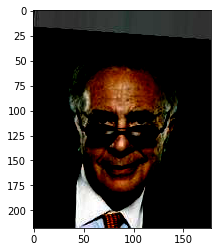

In [117]:
import matplotlib.pyplot as plt
data=siamese_in_creator.celeb_loader.test_dataset[1][0].numpy()

img_disp=np.moveaxis(data, 0, 2)
plt.imshow(img_1_to_run[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


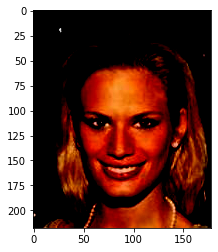

In [118]:
plt.imshow(img_2_to_run[0])

In [309]:
train_data_all=siamese_in_creator.get_images_for_each_class()

In [310]:
test_data_all = siamese_in_creator.get_images_for_each_class(type_ds='test')

In [215]:
sample_classes_train = pd.Series(siamese_in_creator.celeb_loader.train_targets).unique()
sample_classes_test = pd.Series(siamese_in_creator.celeb_loader.test_targets).unique()

common = list(set(sample_classes_train).intersection(sample_classes_test))

In [370]:
def prepare_image(img_original):
    ch,h,w = img_original.shape
    img = np.zeros((1, h, w, ch))
    data = img_original.numpy()
    img_disp = np.moveaxis(data, 0, 2)
    img[0, :, :, :] = img_disp
    return img

In [447]:
def prepare_image_v2(img_original):
    ch,h,w = img_original.shape
    img = np.zeros((1, h, w, ch))
    data = img_original.reshape(h, w, ch)
    img[0, :, :, :] = data
    return img

In [484]:
from sklearn.metrics.pairwise import cosine_similarity

def get_image_class(img_1, img_2):
    
    ynew = identification_one_shot.predict(
        [img_1,img_2]
    )
    return cosine_similarity(ynew[0],ynew[1]).flatten()[0]



In [495]:
similarities = []
matches = []
unmatches = []
import random

train_data, ids_train = train_data_all
test_data, ids_test = test_data_all
unique_vals_to_test=list(pd.Series(ids_test).unique())
for i,val in enumerate(unique_vals_to_test[:40]):
 
    obtained_sim = []
    test_idx = ids_test.index(val)
    train_idx = ids_train.index(val)
    
    img_2_to_run = prepare_image_v2(test_data[test_idx][0])
    false_imgs_10 = random.sample(train_data, 10)
    false_imgs_10.append(train_data[train_idx])
    similarity = {'class':val,
                  'true_match':train_idx,
                  'true_img':img_2_to_run}
    for idx,train_img in enumerate(false_imgs_10):
        img_1_to_run = prepare_image_v2(train_img[0])
        sim = get_image_class(img_2_to_run, img_1_to_run)
        obtained_sim.append(sim)
        if idx == 10:
            actual_sim = sim
            
    max_sim = np.argmax(obtained_sim)
    similarity['result'] = [actual_sim,obtained_sim[max_sim]]
    similarity['obtained_match']= prepare_image_v2(false_imgs_10[max_sim][0])
    similarity['train_match'] = prepare_image_v2(train_data[train_idx][0])
    diff = obtained_sim[max_sim] - actual_sim
    if diff == 0.0:
        matches.append(similarity)
    else:
        unmatches.append(similarity)
    
    similarities.append(similarity)

    
    
    

In [450]:
print(f'Correct labeled images: {len(matches)} wrong: {len(unmatches)}')

Correct labeled images: 16 wrong: 24


In [497]:
print(f'Correct labeled images: {len(matches)} wrong: {len(unmatches)}')

Correct labeled images: 16 wrong: 24


In [493]:
for un in matches:
    print(un['result'])

[0.9622167, 0.9622167]
[0.92864853, 0.92864853]
[0.9574125, 0.9574125]
[0.9669633, 0.9669633]
[0.9482052, 0.9482052]
[0.9466364, 0.9466364]
[0.93939364, 0.93939364]
[0.942526, 0.942526]
[0.9501577, 0.9501577]
[0.93635094, 0.93635094]
[0.93461734, 0.93461734]
[0.9312273, 0.9312273]
[0.9268964, 0.9268964]
[0.94026494, 0.94026494]
[0.95047796, 0.95047796]
[0.9507216, 0.9507216]


In [499]:
show_imgs = ['true_img','obtained_match','train_match']
fig=plt.figure(figsize=(218, 178))
for i,show in enumerate(show_imgs):
    print(show)
    fig.add_subplot(1, 3, i+1)
    plt.imshow(matches[10][show][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true_img
obtained_match
train_match


In [500]:
show_imgs = ['true_img','obtained_match','train_match']
fig=plt.figure(figsize=(218, 178))
for i,show in enumerate(show_imgs):
    print(show)
    fig.add_subplot(1, 3, i+1)
    plt.imshow(unmatches[10][show][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true_img
obtained_match
train_match
